In [2]:
pip install lime

     -------------------------------------- 275.7/275.7 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=f08b30bfd71d66dc17473591f5cc5e7a619af8c27dd7fc6571de3adc9e7ba1c9
  Stored in directory: c:\users\priya\appdata\local\pip\cache\wheels\ed\d7\c9\5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime
Note: you may need to restart the kernel to use updated packages.


In [32]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve,auc

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import warnings
warnings.filterwarnings('ignore')

In [33]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [34]:
# reading and viewing the dataset
df = pd.read_csv(r'data.csv', index_col=0)
df.head()

,path,label
0,Surprise/1bd930d6a1c717c11be33db74823f661cb53f...,Surprise
1,Surprise/cropped_emotions.100096~12fffff.png,Surprise
2,Surprise/0df0e470e33093f5b72a8197fa209d684032c...,Surprise
3,Surprise/cropped_emotions.260779~12fffff.png,Surprise
4,Surprise/cropped_emotions.263616~12fffff.png,Surprise


In [35]:
# creating the global variables
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 75
EPOCHS = 50
DATA = 100

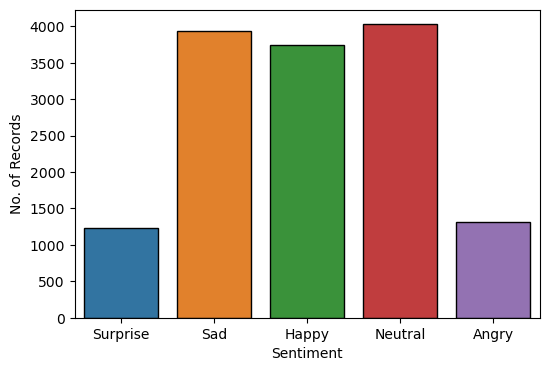

In [5]:
# dropping the unnecessary data
df = df[df['label'] != 'Ahegao']
df['label'].value_counts()

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('No. of Records')
plt.show()

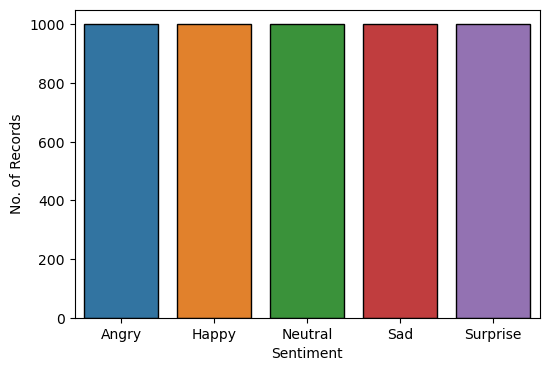

In [6]:
# selecting random 3000 data per sentiment

df = df.groupby('label').sample(DATA).reset_index(drop=True)

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('No. of Records')
plt.show()

In [36]:
# performing label encoding on target variable
label_encoding = LabelEncoder()
df['label'] = label_encoding.fit_transform(df['label'])

In [37]:
# loading the face expression data
def load_data():
    
    images = []
    labels = []
    
    # iterating over each row dataset
    for i, data in df.iterrows():
        image_path = 'dataset/' + data['path']
        label = data['label']
        
        # resizing all the images
        image = cv2.imread(image_path)
        image = cv2.resize(image, IMAGE_SIZE)
        
#         # gray scaling
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         # gaussian blur
#         image = cv2.GaussianBlur(image, (5, 5), 0)
#         # histogram equalization
#         image = cv2.equalizeHist(image)
#         # intensity thresholding
#         _, image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
#         # rgb
#         image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# removing these things from code because it was not giving good accuracy
        
        images.append(image)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    images = images.astype("float32") / 255.0
    labels = to_categorical(labels, 5)
    
    
    return images, labels
    

In [38]:
# reading the image and its corresponding label
img, lab = load_data()
print(f'Image :- {img[25]}')
print(f'Label :- {lab[25]}')

KeyboardInterrupt: 

In [39]:
# splitting data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(img, lab, test_size=0.2, random_state=101, stratify=lab)

print('Training Set', X_train.shape, y_train.shape)
print('Testing Set', X_test.shape, y_test.shape)

Training Set (800, 64, 64, 3) (800, 5)
Testing Set (200, 64, 64, 3) (200, 5)


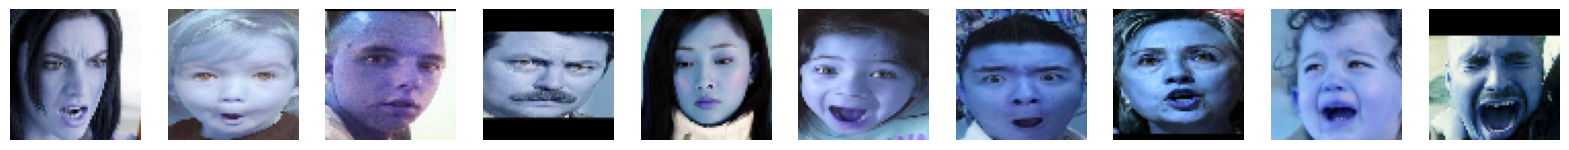

In [40]:
# plotting the faces
plt.figure(figsize=(20, 20))
for i in range(10): 
    plt.subplot(10, 10, 1 + i)
    plt.axis('off')
    plt.imshow(X_train[i])
plt.show()

In [41]:
# performing the data augmentation
train_gen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_data = train_gen.flow(
    X_train,
    y_train
)

In [42]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 64, 64, 3)
(200, 64, 64, 3)
(800, 5)
(200, 5)


In [43]:
# import librarues 
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')
tf.config.run_functions_eagerly(True)

In [44]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim)) 
    return z_mean + K.exp(0.5 * z_log_var) * epsilon 

In [45]:

# def vae_encoder(image_size, latent_dim):
    
#     inputs = Input(shape=(64,64,3), name='encoder_input')
#     # layer 1 with 32 filters
#     x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(inputs) 
#     # layer 2 with 64 filters
#     x = Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x) 
#     x = Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same')(x) # with 1 stride.
#     x = Flatten()(x) # flaton the 3d output from the cnn layer to  1d vector 
#     x = Dense(256, activation='relu')(x)  # danse layer with 256 unites
    
#      # layes with mean of latent dist
#     z_mean = Dense(latent_dim, name='z_mean')(x)  
#     # danse layer with log variance of latent dist
#     z_log_var = Dense(latent_dim, name='z_log_var')(x) 
#     z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])  # apply sampling function 
    
#     encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')  # encoder model
    
#     return encoder

def vae_encoder(image_size, latent_dim):
    inputs = Input(shape=image_size, name='encoder_input')
    x = Conv2D(32, kernel_size=3, strides=2, activation='relu', padding='same')(inputs) 
    x = Conv2D(64, kernel_size=3, strides=2, activation='relu', padding='same')(x) 
    x = Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same')(x)
    x = Flatten()(x) 
    x = Dense(256, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)  
    z_log_var = Dense(latent_dim, name='z_log_var')(x) 
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])  
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')  
    return encoder

In [46]:

# def vae_decoder(latent_dim, output_shape):
    
#     # input layer for decoder name is z sampling 
#     latent_inputs = Input(shape=(latent_dim,), name='z_sampling') 
    
#      # danse layer sample latent vactor as input and produce tensor for 128 dimensions 
#     x = Dense(64 * (output_shape[0] // 4) * (output_shape[1] // 4), activation='relu')(latent_inputs)
#     # reshape output of danse layer to 3d tensor
#     x = Reshape((output_shape[0] // 4, output_shape[1] // 4, 64))(x)   
#     x = Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(x) 
#     x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    
#     # layer for RGB image and generates iutput image
#     outputs = Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(x) 
#     decoder = Model(latent_inputs, outputs, name='decoder') 
#     return decoder

def vae_decoder(latent_dim, output_shape):
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling') 
    x = Dense(64 * (output_shape[0] // 4) * (output_shape[1] // 4), activation='relu')(latent_inputs)
    x = Reshape((output_shape[0] // 4, output_shape[1] // 4, 64))(x)   
    x = Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(x) 
    x = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    outputs = Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(x) 
    decoder = Model(latent_inputs, outputs, name='decoder') 
    return decoder

In [47]:
# Define input shape for the VAE model
input_shape = (64, 64, 3)  # Modify input shape according to your desired image size

# Define VAE encoder and decoder
latent_dim = 64  # Define the latent dimension
encoder = vae_encoder(input_shape, latent_dim)
decoder = vae_decoder(latent_dim, input_shape)

# Define VAE model
inputs = Input(shape=input_shape, name='encoder_input')
outputs = decoder(encoder(inputs)[2])
vae_model = Model(inputs, outputs, name='vae_model')

In [48]:
# compile vae model
vae_model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 

In [49]:
vae_model.fit(X_train, X_train, epochs=5, batch_size=50)

Epoch 1/5
16/16 [==============================] - 3s 194ms/step - loss: 0.0730 - accuracy: 0.7546
Epoch 2/5
16/16 [==============================] - 3s 189ms/step - loss: 0.0681 - accuracy: 0.7948
Epoch 3/5
16/16 [==============================] - 3s 187ms/step - loss: 0.0619 - accuracy: 0.7939
Epoch 4/5
16/16 [==============================] - 3s 186ms/step - loss: 0.0519 - accuracy: 0.7927
Epoch 5/5
16/16 [==============================] - 3s 185ms/step - loss: 0.0397 - accuracy: 0.7947


In [ ]:
vae_model.save("Vae_final1.h5")

In [ ]:
decoder.save('decoder1.h5')

In [50]:
# define input shape
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape, name='encoder_input') # input layer for vae model 

In [51]:
# encoder and decoder models
latent_dim = 64
encoder = vae_encoder(input_shape, latent_dim) # encoder  it take image as input and generate latent variables 
decoder = vae_decoder(latent_dim, input_shape) # decoder take latent variable as imput and generate image 

In [52]:
encoder.save('encoder.h5')

In [53]:
decoder.save('decoder.h5')

In [ ]:
# define vae model
outputs = decoder(encoder(inputs)[2]) # connect encoder and decoder,  
vae = Model(inputs, outputs, name='vae_mlp')

In [ ]:
# compile vae model
vae.compile(optimizer='adam', loss='mse', metrics=['accuracy']) 

# # training the vae model

In [ ]:
vae.fit(X_train, X_train, epochs=5, batch_size=50)

In [ ]:
vae.summary()

In [ ]:
# vae.save_weights("VAE.weights.h5")


In [ ]:
# vae.load_weights("VAE.weights.h5")


In [ ]:
vae.save("Vae_final.h5")

In [ ]:
vae.save('Vae_Final.Kares')

In [ ]:
# Prepare the path to your input image
input_image_path = 'C:/Users/priya/DL/A4/dataset/Happy/00b2b9e9ad753c43e58d54334589ee689fb8a5f4dfbe58f602dda112.jpg'

In [ ]:
def preprocess_input_image(image):
    # Convert image to the appropriate format and perform any necessary preprocessing steps
    # For example, resizing, normalization, etc.
    # Replace this with the actual preprocessing steps used during training
    resized_image = cv2.resize(image, (64, 64))  # Example: Resize image to 64x64 pixels
    normalized_image = resized_image / 255.0  # Example: Normalize pixel values to [0, 1]
    return normalized_image


In [ ]:
from keras.models import load_model

# Load the pre-trained decoder model without including its input layer
decoder = load_model('decoder1.h5', compile=False)

# Load and preprocess the input image
input_image_path = 'C:/Users/priya/DL/A4/dataset/Happy/00b2b9e9ad753c43e58d54334589ee689fb8a5f4dfbe58f602dda112.jpg'
input_image = cv2.imread(input_image_path)
input_image = preprocess_input_image(input_image)  # Apply preprocessing steps

# Encode the input image to obtain latent representation
_, _, latent_representation = encoder.predict(np.array([input_image]))

# Generate the output image using the decoder
generated_image = decoder.predict(latent_representation)

# Display or save the generated image
plt.imshow(generated_image.squeeze())
plt.axis('off')
plt.show()
